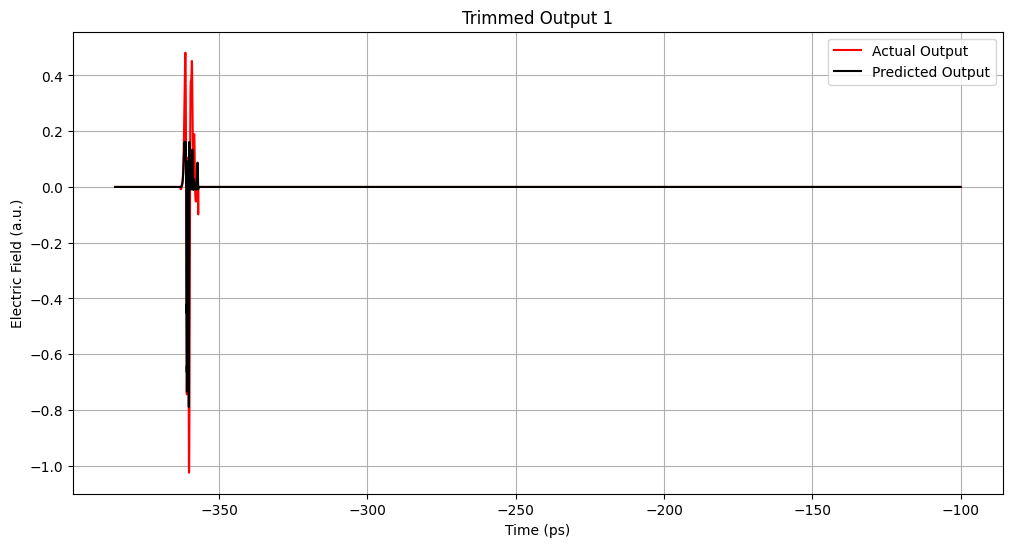

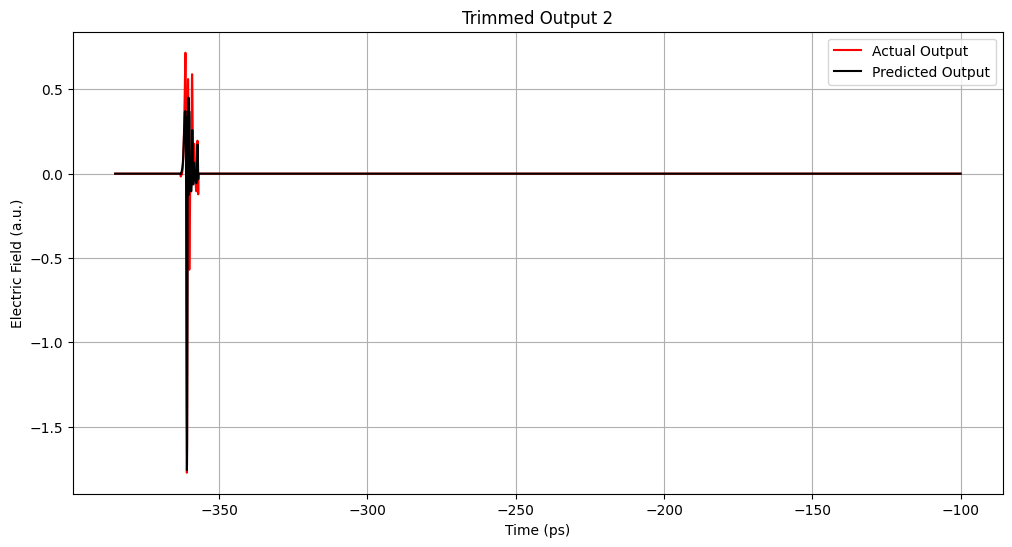

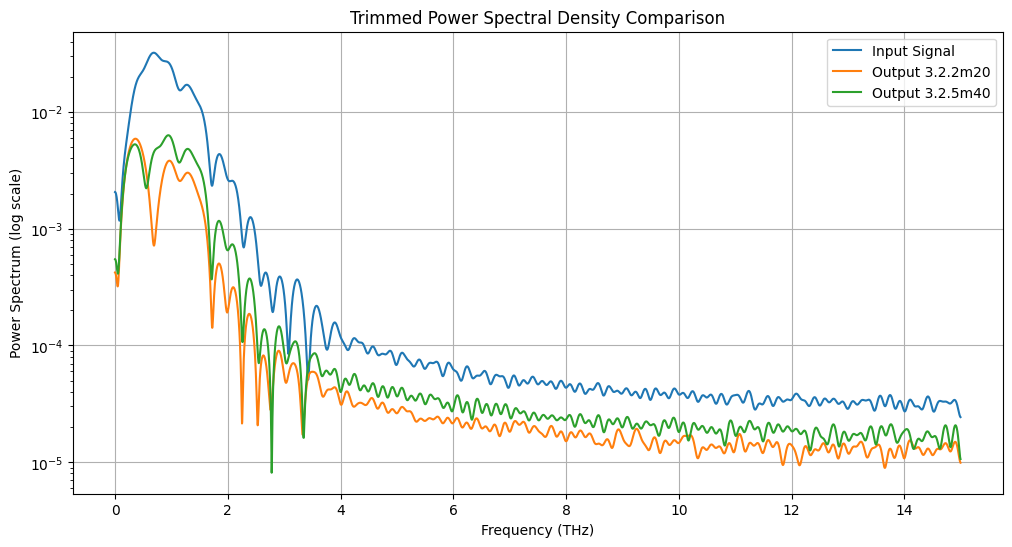

 Time axes are aligned.
 Time axes are aligned.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, fftfreq

""" Ներմուծում ենք անհրաժեշտ գրադարանները՝
numpy՝ թվային հաշվարկների համար,
pandas՝ տվյալների կառավարման համար,
matplotlib՝ գրաֆիկներ կառուցելու համար,
scikit-learn-ից՝ գծային ռեգրեսիայի մոդել և MSE ֆունկցիա,
scipy.fft՝ ազդանշանների հզորության սպեկտր գտնելու համար։ """

def manual_load_data(filename):
    """ Բացվում է տեքստային ֆայլ, և ընթերցվում է ժամանակային ու էլեկտրական դաշտի տվյալները։
    Բաց են թողնվում դատարկ և մեկնաբանված տողերը։ Վերադարձվում է pandas DataFrame։ """
    times = []
    fields = []
    with open(filename, 'r') as f:
        for line in f:
            if not line.strip() or line.startswith('#'):
                continue
            parts = line.replace(',', ' ').split()
            if len(parts) >= 2:
                try:
                    times.append(float(parts[0]))
                    fields.append(float(parts[1]))
                except ValueError:
                    continue
    return pd.DataFrame({'Time (ps)': times, 'Electric Field (a.u.)': fields})

# Տվյալների ներբեռնում ֆայլերից
input_data_1 = manual_load_data('1.2.txt')
input_data_2 = manual_load_data('3.2.0.txt')
output_data_1 = manual_load_data('3.2.2m20.txt')
output_data_2 = manual_load_data('3.2.5m40.txt')

def trim_signal(time, signal, start=-363, end=-357):
    """ Զրոյացնում է ազդանշանի այն հատվածները, որոնք դուրս են տրված ժամանակային միջակայքից։ """
    return np.where((time >= start) & (time <= end), signal, 0)

def calculate_power_spectrum(time, signal):
    """ Հաշվում է ազդանշանի հզորության սպեկտրը՝ օգտագործելով Ֆուրիեի արագ փոխակերպում։ """
    N = len(signal)
    dt = time[1] - time[0]  # ժամանակային քայլին
    yf = fft(signal)        # Ֆուրիեի փոխակերպում
    xf = fftfreq(N, dt)[:N//2]  # Հաճախականության առանցք
    power = 2/N * np.abs(yf[:N//2])  # Նորմավորված հզորության արժեքներ
    return xf, power

def create_features(E, n):
    """ Ստեղծում է E, E^2, ..., E^n ֆիչերները մոդելի համար՝ ոչգծային հատկությունների համար։ """
    return np.column_stack([E**i for i in range(1, n+1)])

def train_model(input_data, output_data, n):
    """ Ուսուցանում է գծային ռեգրեսիայի մոդել՝ օգտվելով n աստիճանի ֆիչերներից։
    Վերադարձնում է՝ մոդել, միջին քառակուսային սխալ և կանխատեսված արժեքներ։ """
    X = create_features(input_data['Electric Field (a.u.)'].values, n)
    y = output_data['Electric Field (a.u.)'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    return model, mse, y_pred

# Փորձարկվող աստիճանները
n_values = [2, 5, 10]
models = {}

# Յուրաքանչյուր n-ի համար ուսուցանում ենք մոդել և պահում արդյունքները
for n in n_values:
    m1, mse1, pred1 = train_model(input_data_1, output_data_1, n)
    models[f'n={n}_output1'] = {'model': m1, 'mse': mse1, 'pred': pred1}
    m2, mse2, pred2 = train_model(input_data_1, output_data_2, n)
    models[f'n={n}_output2'] = {'model': m2, 'mse': mse2, 'pred': pred2}

def plot_trimmed_comparison(input_data, output_data, model_info, n, title):
    """ Նկարագրում է կանխատեսված և իրական ելքային ազդանշանները՝ միայն պուլսային հատվածում։
    Ցույց է տալիս՝ որքանով լավ է մոդելը վերարտադրում ելքային ազդանշանը։ """
    t = input_data['Time (ps)'].values
    E = input_data['Electric Field (a.u.)'].values
    X = create_features(E, n)
    y_pred = model_info['model'].predict(X)
    trimmed_actual = trim_signal(t, output_data['Electric Field (a.u.)'].values)
    trimmed_pred = trim_signal(t, y_pred)

    plt.figure(figsize=(12, 6))
    plt.plot(t, trimmed_actual, label='Actual Output', color='red')
    plt.plot(t, trimmed_pred, label='Predicted Output', color='black')
    plt.xlabel('Time (ps)')
    plt.ylabel('Electric Field (a.u.)')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

# Որոնում ենք լավագույն n արժեքը՝ ըստ նվազագույն MSE-ի
best_n1 = min(n_values, key=lambda x: models[f'n={x}_output1']['mse'])
best_n2 = min(n_values, key=lambda x: models[f'n={x}_output2']['mse'])

# Նկարում ենք արդյունքները՝ լավագույն n-ով
plot_trimmed_comparison(input_data_1, output_data_1, models[f'n={best_n1}_output1'], best_n1, 'Trimmed Output 1')
plot_trimmed_comparison(input_data_1, output_data_2, models[f'n={best_n2}_output2'], best_n2, 'Trimmed Output 2')

# Հաշվում ենք հզորության սպեկտրները՝ trimmed ազդանշանների համար
xf_input, power_input = calculate_power_spectrum(
    input_data_1['Time (ps)'].values,
    trim_signal(input_data_1['Time (ps)'].values, input_data_1['Electric Field (a.u.)'].values)
)
xf_output1, power_output1 = calculate_power_spectrum(
    output_data_1['Time (ps)'].values,
    trim_signal(output_data_1['Time (ps)'].values, output_data_1['Electric Field (a.u.)'].values)
)
xf_output2, power_output2 = calculate_power_spectrum(
    output_data_2['Time (ps)'].values,
    trim_signal(output_data_2['Time (ps)'].values, output_data_2['Electric Field (a.u.)'].values)
)

# Նկարում ենք trimmed ազդանշանների հզորության սպեկտրների համեմատությունը
plt.figure(figsize=(12, 6))
plt.semilogy(xf_input, power_input, label='Input Signal')
plt.semilogy(xf_output1, power_output1, label='Output 3.2.2m20')
plt.semilogy(xf_output2, power_output2, label='Output 3.2.5m40')
plt.xlabel('Frequency (THz)')
plt.ylabel('Power Spectrum (log scale)')
plt.title('Trimmed Power Spectral Density Comparison')
plt.legend()
plt.grid()
plt.show()

def check_time_alignment(input_data, output_data):
    """ Ստուգում է՝ արդյոք input և output տվյալների ժամանակային առանցքները համընկնում են։
    Եթե ոչ, ապա անհրաժեշտ է հարմարեցում/ինտերպոլյացիա։ """
    t1 = input_data['Time (ps)'].values
    t2 = output_data['Time (ps)'].values
    if np.allclose(t1, t2):
        print(" Time axes are aligned.")
    else:
        print("Time axes are NOT aligned. Consider interpolating or aligning.")

# Ստուգում ենք ժամանակային համընկնումը՝ նախքան մոդելի ուսուցումը
check_time_alignment(input_data_1, output_data_1)
check_time_alignment(input_data_1, output_data_2)


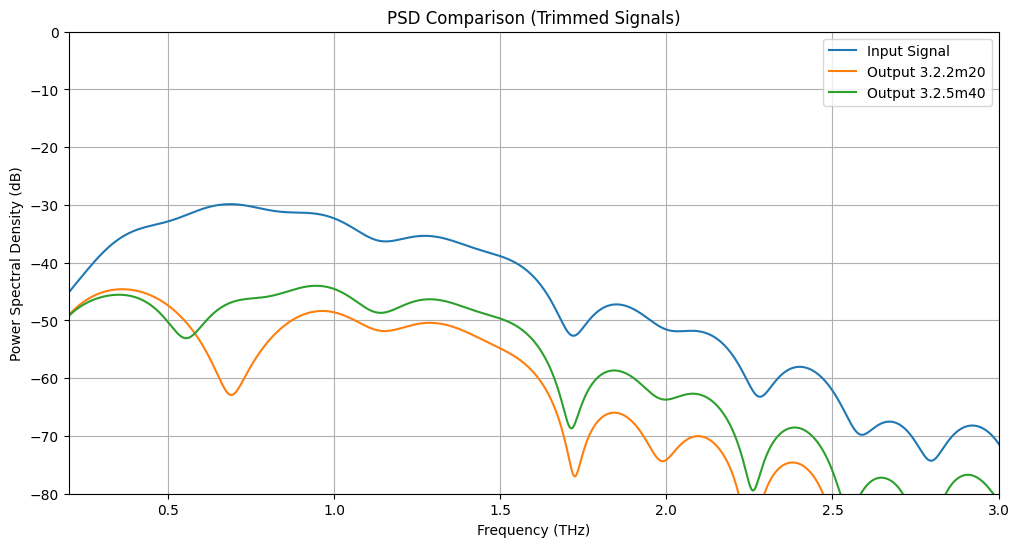

In [14]:
def trim_signal_in_time(time, signal, t_min=-363, t_max=-357):
    """ Կտրում ենք ազդանշանի ժամանակային հատվածը միայն [t_min, t_max] միջակայքում։
    Մնացած հատվածները զրոյացնում ենք։ """
    return np.where((time >= t_min) & (time <= t_max), signal, 0)

def calculate_power_spectrum_dB(time, signal):
    """ Հաշվում ենք ազդանշանի հզորության սպեկտրը (Power Spectral Density) դեցիբելային սանդղակով։
    Օգտագործում ենք FFT՝ ֆրեքվենսիաների և հզորության դիստրիբյուցիայի ստացման համար։
    1e-12 ավելացնում ենք՝ log(0)-ից խուսափելու համար։ """
    N = len(signal)
    dt = time[1] - time[0]               # ժամանակային քայլին՝ նմուշների միջև
    yf = fft(signal)                    # Fast Fourier Transform՝ ստանալու սպեկտր
    xf = fftfreq(N, dt)[:N//2]         # Հաճախականության առանցք՝ միայն առաջին կեսը (նույնն է սպեկտրի համար)
    power_linear = (2.0 / N) * np.abs(yf[:N//2])   # Նորմավորված հզորություն
    power_dB = 20 * np.log10(power_linear + 1e-12) # Դեցիբելային սանդղակ՝ խուսափելով log(0)-ից
    return xf, power_dB

# --- Կտրում ենք միայն պուլսային հատվածները (trim)՝ input և երկու տարբեր output ազդանշանների համար ---
trimmed_input = trim_signal_in_time(input_data_1['Time (ps)'].values,
                                     input_data_1['Electric Field (a.u.)'].values)
trimmed_output1 = trim_signal_in_time(output_data_1['Time (ps)'].values,
                                      output_data_1['Electric Field (a.u.)'].values)
trimmed_output2 = trim_signal_in_time(output_data_2['Time (ps)'].values,
                                      output_data_2['Electric Field (a.u.)'].values)

# --- Հաշվում ենք PSD (Power Spectral Density) դեցիբելային սանդղակով ---
xf_input, psd_input = calculate_power_spectrum_dB(input_data_1['Time (ps)'].values, trimmed_input)
xf_output1, psd_output1 = calculate_power_spectrum_dB(output_data_1['Time (ps)'].values, trimmed_output1)
xf_output2, psd_output2 = calculate_power_spectrum_dB(output_data_2['Time (ps)'].values, trimmed_output2)

# --- Գծապատկեր: Հզորության սպեկտրի համեմատություն trimmed ազդանշանների համար ---
plt.figure(figsize=(12, 6))
plt.plot(xf_input, psd_input, label='Input Signal')            # Ներմուծված ազդանշան
plt.plot(xf_output1, psd_output1, label='Output 3.2.2m20')     # Առաջին ելքային ազդանշան
plt.plot(xf_output2, psd_output2, label='Output 3.2.5m40')     # Երկրորդ ելքային ազդանշան
plt.xlim(0.2, 3)                                               # Սահմանում ենք հետաքրքիր հաճախականության տիրույթը՝ (0.2 – 3 THz)
plt.ylim(-80, 0)                                               # Դեցիբելային սանդղակ՝ -80-ից մինչև 0 dB
plt.xlabel('Frequency (THz)')                                  # Հաճախականության առանցք
plt.ylabel('Power Spectral Density (dB)')                      # Ուժգնության առանցք՝ դեցիբելներով
plt.title('PSD Comparison (Trimmed Signals)')                  # Գրաֆիկի վերնագիր
plt.grid(True)                                                 # Ցանց՝ հեշտ համեմատության համար
plt.legend()                                                   # Լեգենդ՝ տարբեր գծերի նշմամբ
plt.show()                                                     # Ցուցադրում ենք գծապատկերը


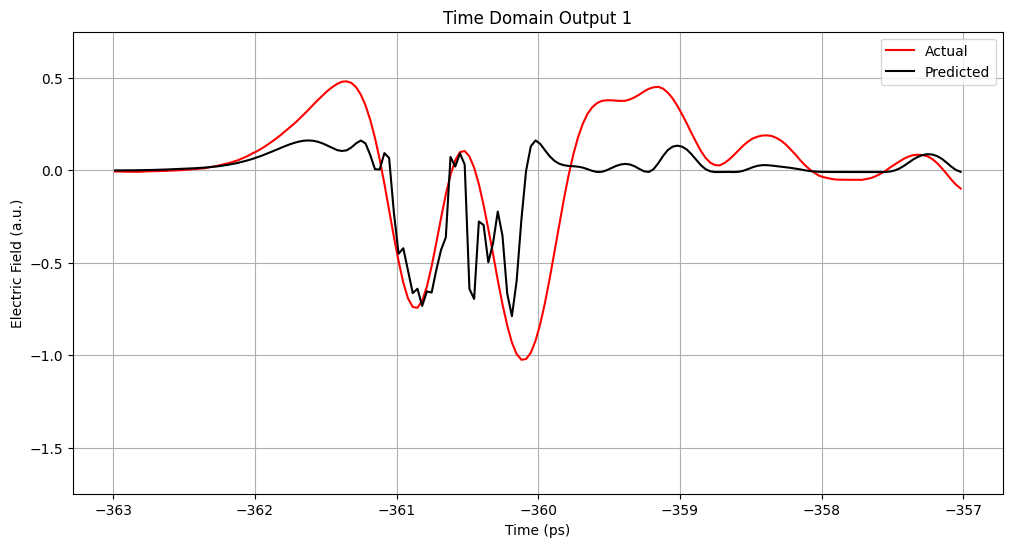

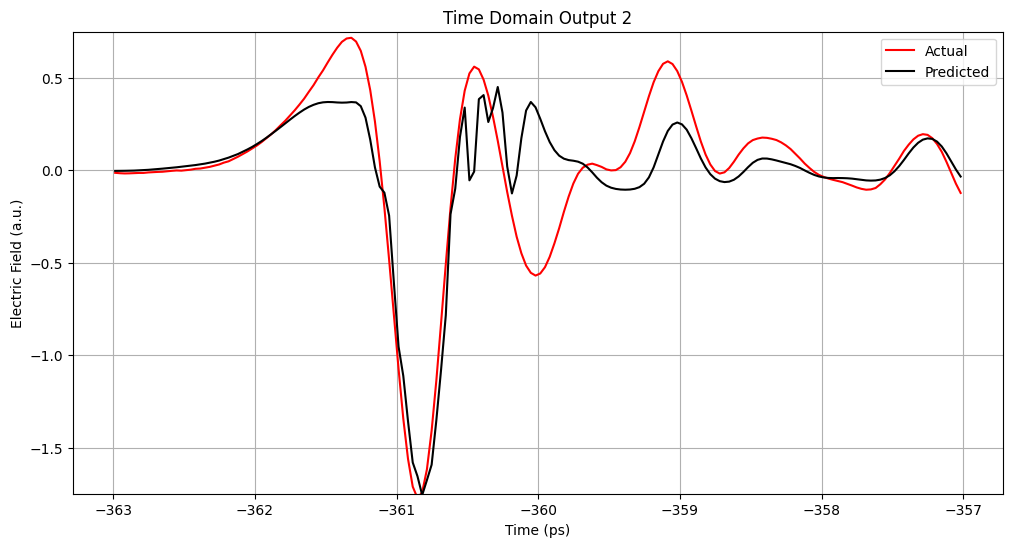

In [17]:
def plot_time_trimmed_output(input_data, output_data, model_info, n, title):
    """ 
    Նկարում է կանխատեսված և իրական ելքային ազդանշանները ժամանակային տիրույթում՝ միայն պուլսային միջակայքում։ 
    
    Մուտք՝
        input_data — pandas DataFrame, պարունակում է 'Time (ps)' և 'Electric Field (a.u.)'
        output_data — pandas DataFrame, նույն կառուցվածքով՝ սպասվող ելք
        model_info — բառարան, որն ունի ուսուցված մոդել՝ key 'model'
        n — պոլինոմի աստիճան (feature-ի աստիճան, որը կիրառվել է train ժամանակ)
        title — գրաֆիկի վերնագիր
    """

    # --- Step 1: Ստանում ենք ժամանակային և ինփութ էլեկտրական դաշտի արժեքները ---
    t = input_data['Time (ps)'].values
    E = input_data['Electric Field (a.u.)'].values

    # --- Step 2: Ստեղծում ենք նույն պոլինոմ ֆիչերները ինչ train-ի ժամանակ ---
    X = np.column_stack([E**i for i in range(1, n+1)])
    y_pred = model_info['model'].predict(X)  # Կանխատեսում

    # --- Step 3: Տեղի է ունենում trimmed հատվածի առանձնացում՝ ըստ ժամանակի ---
    mask = (t >= -363) & (t <= -357)
    t_trim = t[mask]                             # Trimmed ժամանակ
    y_actual_trim = output_data['Electric Field (a.u.)'].values[mask]  # Իրական trimmed ելք
    y_pred_trim = y_pred[mask]                   # Կանխատեսված trimmed ելք

    # --- Step 4: Նկարագրում ենք trimmed հատվածի իրական և կանխատեսված ելքային ազդանշանները ---
    plt.figure(figsize=(12, 6))
    plt.plot(t_trim, y_actual_trim, label='Actual', color='red')     # Իրական ելք (կարմիր)
    plt.plot(t_trim, y_pred_trim, label='Predicted', color='black')  # Կանխատեսված ելք (սև)
    plt.ylim(-1.75, 0.75)                                             # Վիզուալ հարմար y-շեղում
    plt.xlabel('Time (ps)')
    plt.ylabel('Electric Field (a.u.)')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()
plot_time_trimmed_output(
    input_data_1, output_data_1, models[f'n={best_n1}_output1'], best_n1, 
    'Time Domain Output 1'
)

plot_time_trimmed_output(
    input_data_1, output_data_2, models[f'n={best_n2}_output2'], best_n2, 
    'Time Domain Output 2'
)


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def create_features(E, n):
    """ Ստեղծում է n աստիճանի պոլինոմ ֆիչերներ՝ [E, E^2, ..., E^n]։
    Մուտք՝ 
        E - numpy զանգված (էլեկտրական դաշտի արժեքներ)
        n - պոլինոմի առավելագույն աստիճան
    Ելք՝ 
        ֆիչերների մատրից՝ որի սյունակներն են E^1, E^2, ..., E^n
    """
    return np.column_stack([E**i for i in range(1, n+1)])

def train_model_no_scaling(input_data, output_data, n):
    """ Ուսուցանում է գծային ռեգրեսիոն մոդել՝ օգտագործելով n աստիճանի պոլինոմ ֆիչերներ։
    
    Մուտք՝
        input_data - pandas DataFrame, որը պարունակում է 'Electric Field (a.u.)' սյունակ (ինփուտ)
        output_data - pandas DataFrame, որը պարունակում է 'Electric Field (a.u.)' սյունակ (ելք)
        n - պոլինոմի աստիճանը
        
    Կատարում է՝
        - ֆիչերների մատրիցի ստեղծում (բառացիորեն առանց սկեյլինգի)
        - մոդելի ուսուցում (LinearRegression)
        - կանխատեսում
        - միջին քառակուսային սխալի հաշվարկ
        
    Ելք՝
        model - ուսուցված LinearRegression մոդել
        mse - միջին քառակուսային սխալ (mean squared error)
    """
    X = create_features(input_data['Electric Field (a.u.)'].values, n)
    y = output_data['Electric Field (a.u.)'].values
    
    model = LinearRegression()
    model.fit(X, y)  # Մոդելի ուսուցում
    
    y_pred = model.predict(X)  # Կանխատեսում՝ նույն տվյալների վրա
    mse = mean_squared_error(y, y_pred)  # Քանակական սխալի գնահատում
    
    print(f"Model trained with n={n}, MSE = {mse:.6f}")
    return model, mse


In [19]:
n_values = [2, 5, 10]  
""" Սա այն պոլինոմ աստիճանների ցանկն է, որոնցով ուզում ենք ուսուցանել մոդելները։
Փորձում ենք 2-րդ, 5-րդ և 10-րդ աստիճանի ռեգրեսիոն մոդելներ։ """

models = {}  
""" Սա դատարկ բառարան է, որտեղ պահպանելու ենք յուրաքանչյուր մոդելի պարամետրերը՝ 
համապատասխանաբար ելքային ազդանշանների համար ('output1' և 'output2')։
Բանալին կլինի օրինակ՝ 'n=2_output1'։
Արժեքը՝ {'model': <LinearRegression>, 'mse': ...} 
"""

for n in n_values:
    """ Պտտվում ենք յուրաքանչյուր պոլինոմ աստիճանի համար՝ n=2, 5, 10։ """

    model1, mse1 = train_model_no_scaling(input_data_1, output_data_1, n)
    """ Ուսուցանում ենք մոդել `input_data_1` և `output_data_1`-ի համար՝ առանց սկեյլինգի։
    Ստանում ենք մոդել և դրա միջին քառակուսային սխալը (MSE)։ """

    models[f'n={n}_output1'] = {'model': model1, 'mse': mse1}
    """ Արդյունքը պահում ենք բառարանում՝ բանալին կազմելով ըստ աստիճանի և ելքի անունի։ """

    model2, mse2 = train_model_no_scaling(input_data_1, output_data_2, n)
    """ Կրկնում ենք նույնը՝ երկրորդ ելքի համար (`output_data_2`)։ """

    models[f'n={n}_output2'] = {'model': model2, 'mse': mse2}
    """ Պահպանում ենք երկրորդ ելքի մոդելն ու սխալը։ """


Model trained with n=2, MSE = 0.001970
Model trained with n=2, MSE = 0.001465
Model trained with n=5, MSE = 0.001882
Model trained with n=5, MSE = 0.001401
Model trained with n=10, MSE = 0.001643
Model trained with n=10, MSE = 0.001228


In [40]:
def print_coefficients(model_info, n):
    """
    Տպում է ռեգրեսիոն մոդելի կոեֆիցիենտները՝ ներառյալ ինտերպցիան և յուրաքանչյուր աստիճանի կշիռը։

    Մուտք՝
        model_info — բառարան, որը պարունակում է 'model' բանալիով LinearRegression օբյեկտ
        n — պոլինոմ աստիճան, որը ցույց է տալիս ֆիչերների քանակը (E, E^2, ..., E^n)
    """

    model = model_info['model']  # Ստանում ենք LinearRegression մոդելը
    print(f"\nCoefficients for n={n}:")  # Տպում ենք վերնագիր՝ որ n-ի համար է

    # Տպում ենք ինտերպցիան՝ մոդելի հիմնագիծը, երբ բոլոր E^i-ները 0 են
    print(f"Intercept (m): {model.intercept_:.6f}")

    # Տպում ենք յուրաքանչյուր կշիռ (կոեֆիցիենտ) ըստ պոլինոմի աստիճանի՝ E^1, E^2, ..., E^n
    for i, coef in enumerate(model.coef_, 1):
        print(f"a{i}: {coef:.6f}")  # օրինակ՝ a1: ..., a2: ..., և այլն
for n in n_values:
    print_coefficients(models[f'n={n}_output1'], n)  # Տպում ենք առաջին ելքի մոդելի կոեֆիցիենտները
    print_coefficients(models[f'n={n}_output2'], n)  # Տպում ենք երկրորդ ելքի մոդելի կոեֆիցիենտները



Coefficients for n=2:
Intercept (m): 0.001745
a1: -0.011706
a2: -0.013926

Coefficients for n=2:
Intercept (m): 0.001249
a1: 0.136104
a2: -0.010460

Coefficients for n=5:
Intercept (m): 0.001888
a1: 0.057779
a2: -0.035404
a3: -0.005096
a4: 0.000654
a5: 0.000099

Coefficients for n=5:
Intercept (m): 0.001238
a1: 0.198218
a2: -0.021221
a3: -0.004409
a4: 0.000214
a5: 0.000058

Coefficients for n=10:
Intercept (m): 0.000584
a1: 0.073115
a2: 0.128939
a3: -0.022537
a4: -0.038445
a5: -0.001807
a6: 0.002579
a7: 0.000335
a8: -0.000042
a9: -0.000010
a10: -0.000000

Coefficients for n=10:
Intercept (m): 0.000146
a1: 0.215685
a2: 0.114681
a3: -0.021824
a4: -0.031635
a5: -0.001181
a6: 0.002087
a7: 0.000259
a8: -0.000034
a9: -0.000008
a10: -0.000000


In [41]:
from sklearn.linear_model import Ridge, Lasso

def train_model_on_trimmed(E_input_trim, E_output_trim, n, model_type='ridge', alpha=1.0):
    """
    Ուսուցանում է Ridge կամ Lasso ռեգրեսիա՝ trimmed (կտրված) ազդանշանների վրա՝ օգտագործելով պոլինոմ ֆիչերներ։

    Մուտք՝
        E_input_trim — numpy զանգված, trimmed ինփուտ ազդանշան (Electric Field)
        E_output_trim — numpy զանգված, trimmed ելքային ազդանշան (Electric Field)
        n — պոլինոմ ֆիչերների առավելագույն աստիճան
        model_type — 'ridge' կամ 'lasso', որոշում է թե որ մոդելն օգտագործել
        alpha — կարգավորման պարամետր (regularization strength)

    Ելք՝
        model — ուսուցված Ridge կամ Lasso մոդել
        mse — ուսուցման տվյալների վրա հաշվված միջին քառակուսային սխալը
    """

    # --- Ստեղծում ենք պոլինոմ ֆիչերներ՝ [E, E^2, ..., E^n] ---
    X = create_features(E_input_trim, n)
    y = E_output_trim

    # --- Ընտրում ենք մոդելի տիպը՝ Ridge կամ Lasso ---
    if model_type == 'ridge':
        model = Ridge(alpha=alpha)
    elif model_type == 'lasso':
        model = Lasso(alpha=alpha, max_iter=10000)
    else:
        raise ValueError("Unknown model type.")  # Սխալ մոդելի անունի դեպքում

    # --- Ուսուցում և կանխատեսում ---
    model.fit(X, y)                  # Մոդելի ուսուցում
    y_pred = model.predict(X)       # Կանխատեսում նույն ֆիչերների վրա
    mse = mean_squared_error(y, y_pred)  # MSE հաշվարկ՝ որպես սխալի չափանիշ

    # --- Տպում ենք արդյունքները ---
    print(f"{model_type.capitalize()} Regression | n={n}, alpha={alpha} | MSE = {mse:.6f}")

    return model, mse


In [42]:
n_values = [2, 5, 10]  
""" Ստեղծում ենք պոլինոմ աստիճանների ցուցակ՝ որոնցով ուզում ենք փորձարկել մոդելները։ """

alphas = {'ridge': 0.5, 'lasso': 0.01}  
""" Սահմանում ենք կարգավորման ուժերը (regularization strength) երկու մոդելների համար։ 
Ridge-ն ավելի մեծ alpha է ստանում, քանի որ այն ավելի կայուն է։
Lasso-ի համար ընտրում ենք ավելի փոքր alpha՝ ֆիչերների կրճատման էֆեկտը տեսնելու համար։
"""

print("🔷 Trimmed Output 1:")  
""" Սկսում ենք առաջին ելքային ազդանշանի վերլուծությունը։ """

for n in n_values:
    """ Պտտվում ենք յուրաքանչյուր պոլինոմ աստիճանի համար։ """

    train_model_on_trimmed(
        trimmed_input, trimmed_output1, n,
        model_type='ridge', alpha=alphas['ridge']
    )
    """ Ուսուցանում ենք Ridge մոդել՝ տրված alpha-ով։ """

    train_model_on_trimmed(
        trimmed_input, trimmed_output1, n,
        model_type='lasso', alpha=alphas['lasso']
    )
    """ Ուսուցանում ենք Lasso մոդել՝ իր alpha-ով։ """


print("\n🔷 Trimmed Output 2:")  
""" Կրկնում ենք նույն գործընթացը՝ երկրորդ ելքային ազդանշանի համար։ """

for n in n_values:
    train_model_on_trimmed(
        trimmed_input, trimmed_output2, n,
        model_type='ridge', alpha=alphas['ridge']
    )
    train_model_on_trimmed(
        trimmed_input, trimmed_output2, n,
        model_type='lasso', alpha=alphas['lasso']
    )


🔷 Trimmed Output 1:
Ridge Regression | n=2, alpha=0.5 | MSE = 0.001776
Lasso Regression | n=2, alpha=0.01 | MSE = 0.001829
Ridge Regression | n=5, alpha=0.5 | MSE = 0.001737
Lasso Regression | n=5, alpha=0.01 | MSE = 0.001784
Ridge Regression | n=10, alpha=0.5 | MSE = 0.001488


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.99861e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.537e+00, tolerance: 2.016e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.99861e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Lasso Regression | n=10, alpha=0.01 | MSE = 0.001720

🔷 Trimmed Output 2:
Ridge Regression | n=2, alpha=0.5 | MSE = 0.001307
Lasso Regression | n=2, alpha=0.01 | MSE = 0.002339
Ridge Regression | n=5, alpha=0.5 | MSE = 0.001276
Lasso Regression | n=5, alpha=0.01 | MSE = 0.001579
Ridge Regression | n=10, alpha=0.5 | MSE = 0.001103
Lasso Regression | n=10, alpha=0.01 | MSE = 0.001605


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.025e+00, tolerance: 3.567e-03
  model = cd_fast.enet_coordinate_descent(



🔷 Ridge / Lasso results for Output 1 (No Scaling, Cut):
Ridge | n=2, alpha=0.5 | MSE = 0.077783


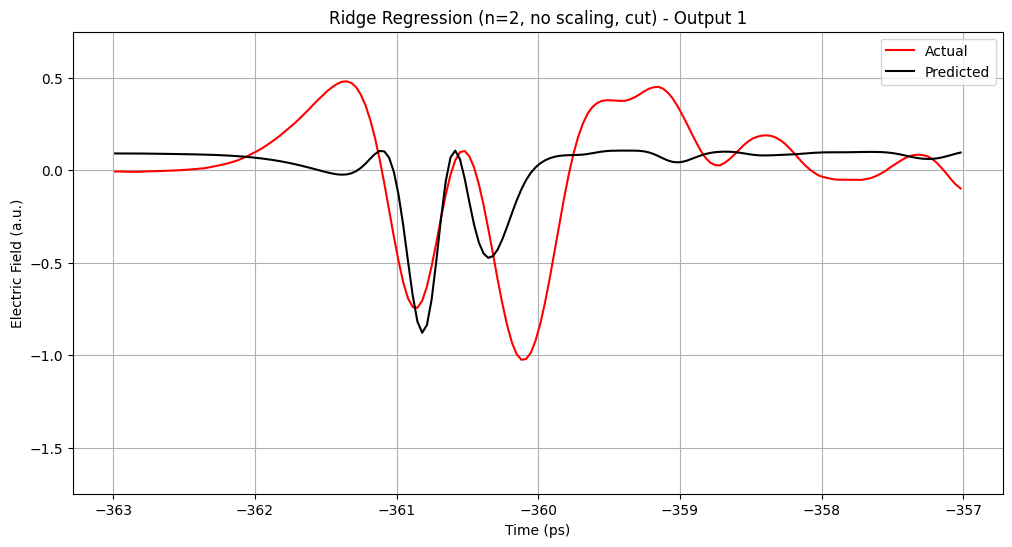

Lasso | n=2, alpha=0.01 | MSE = 0.077830


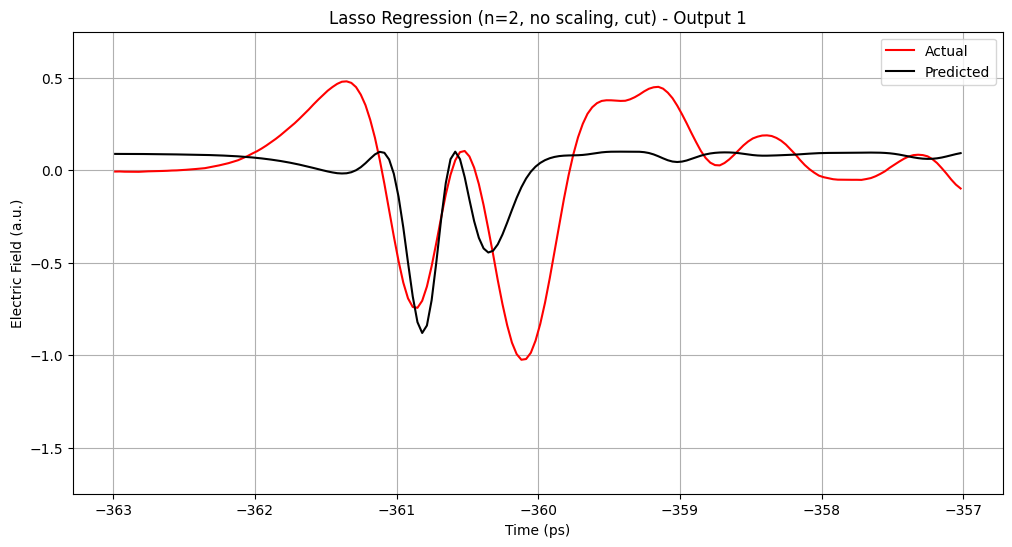

Ridge | n=5, alpha=0.5 | MSE = 0.074280


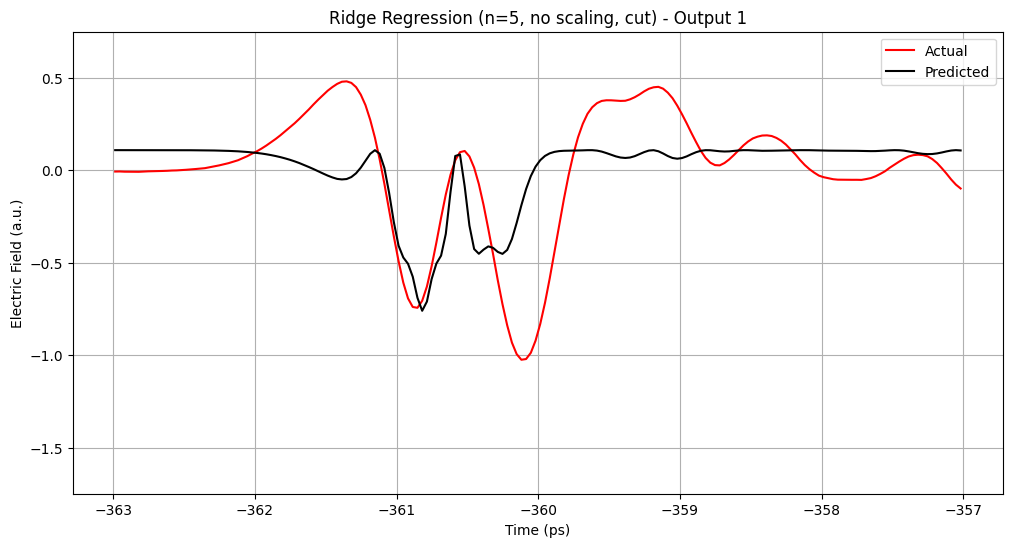

Lasso | n=5, alpha=0.01 | MSE = 0.074338


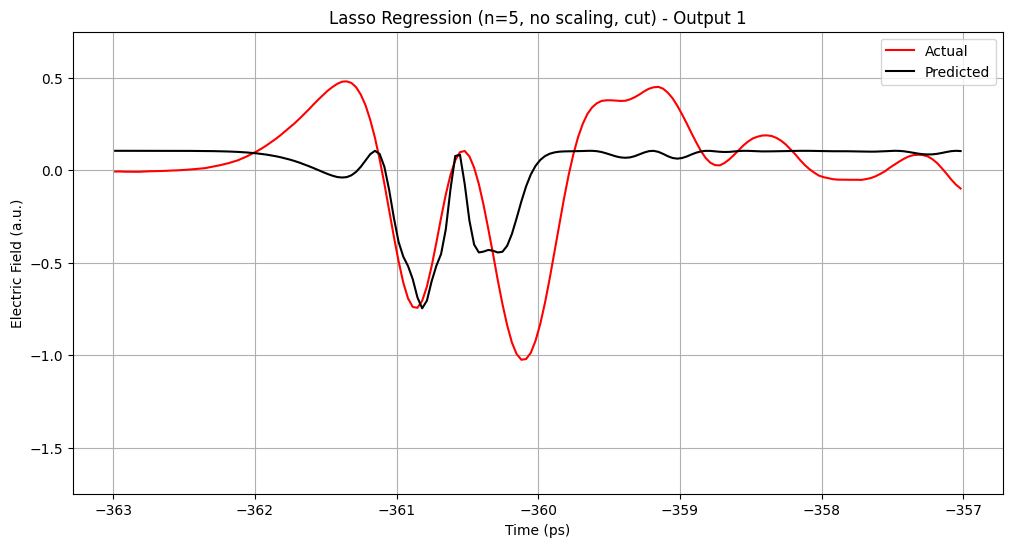

Ridge | n=10, alpha=0.5 | MSE = 0.067827


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.09279e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


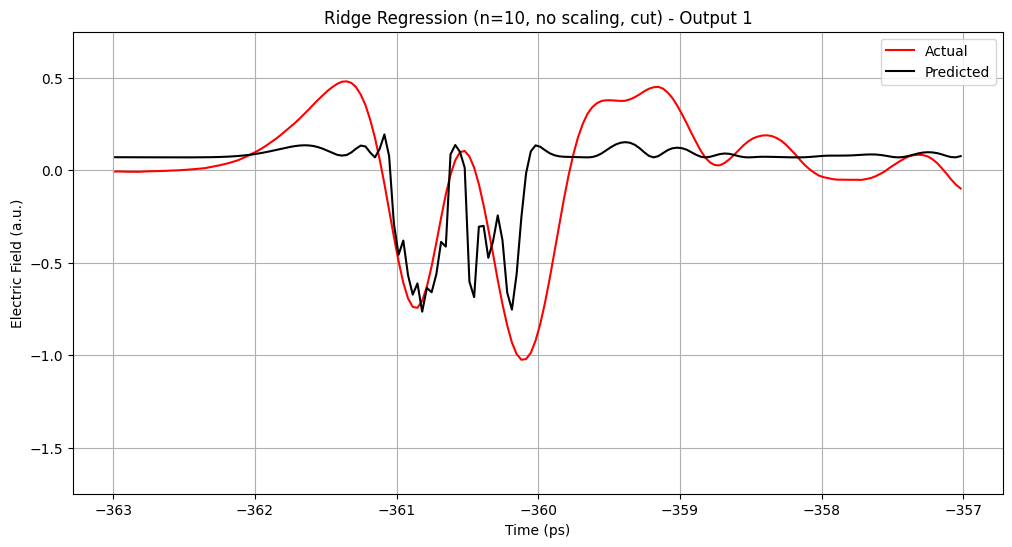

Lasso | n=10, alpha=0.01 | MSE = 0.072332


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.523e+00, tolerance: 2.015e-03
  model = cd_fast.enet_coordinate_descent(


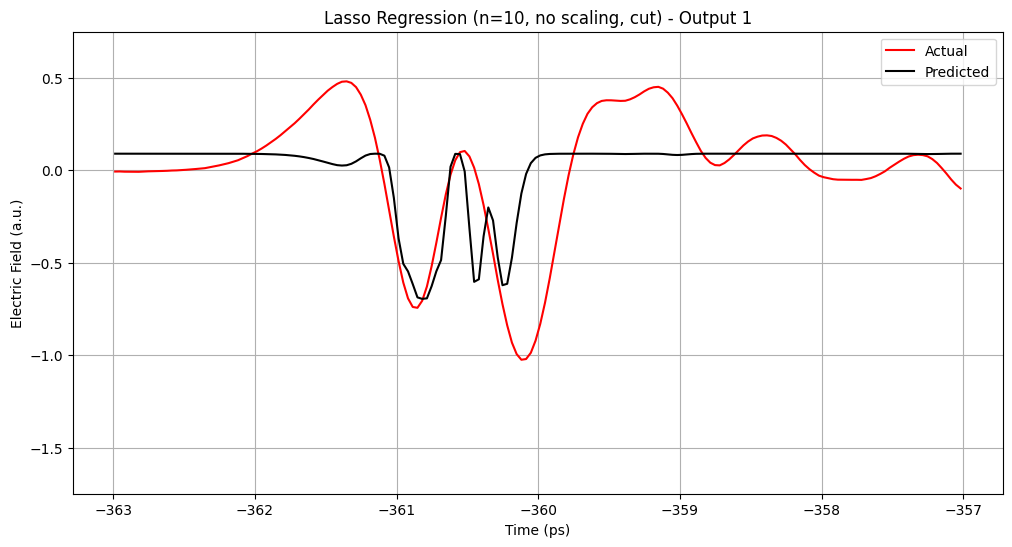


🔷 Ridge / Lasso results for Output 2 (No Scaling, Cut):
Ridge | n=2, alpha=0.5 | MSE = 0.058577


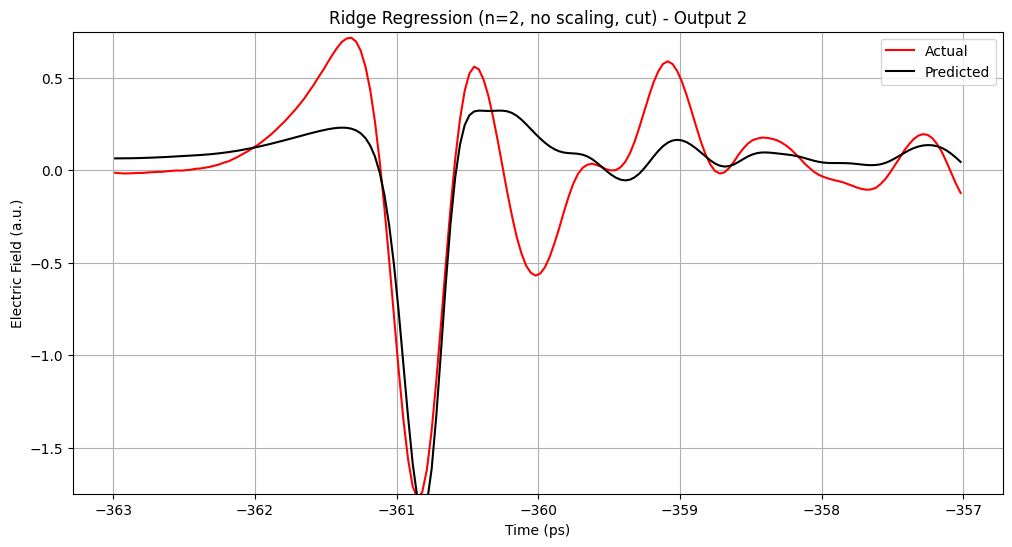

Lasso | n=2, alpha=0.01 | MSE = 0.058608


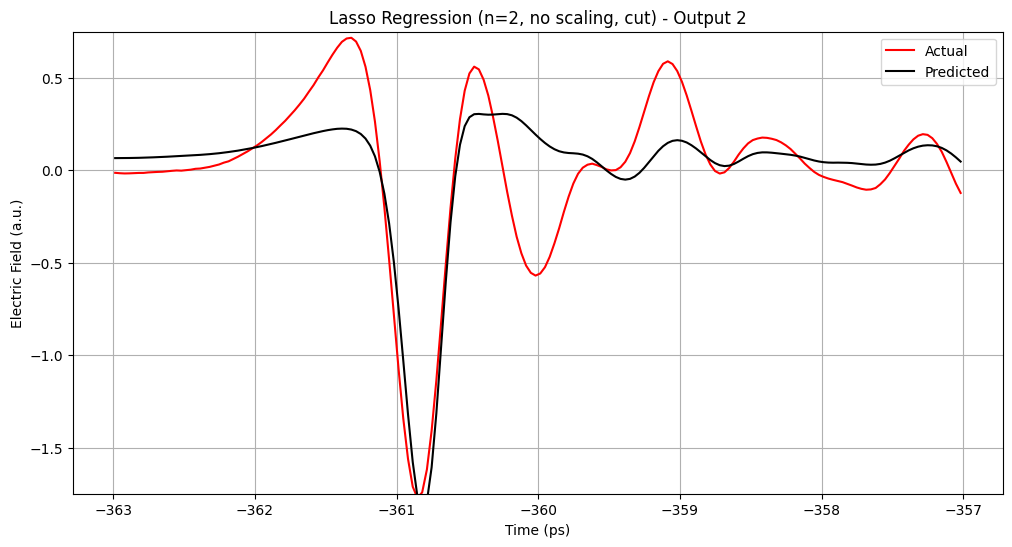

Ridge | n=5, alpha=0.5 | MSE = 0.056950


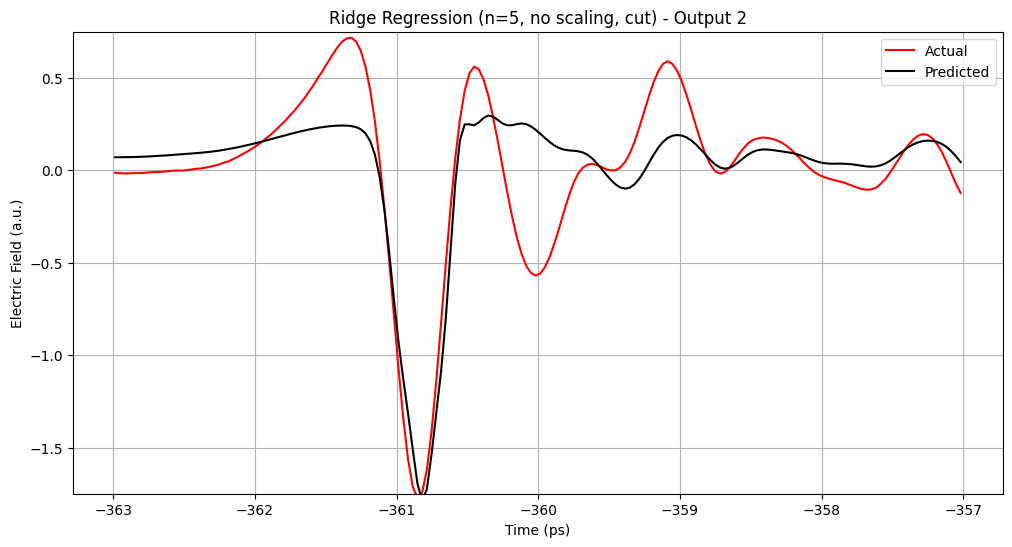

Lasso | n=5, alpha=0.01 | MSE = 0.057362


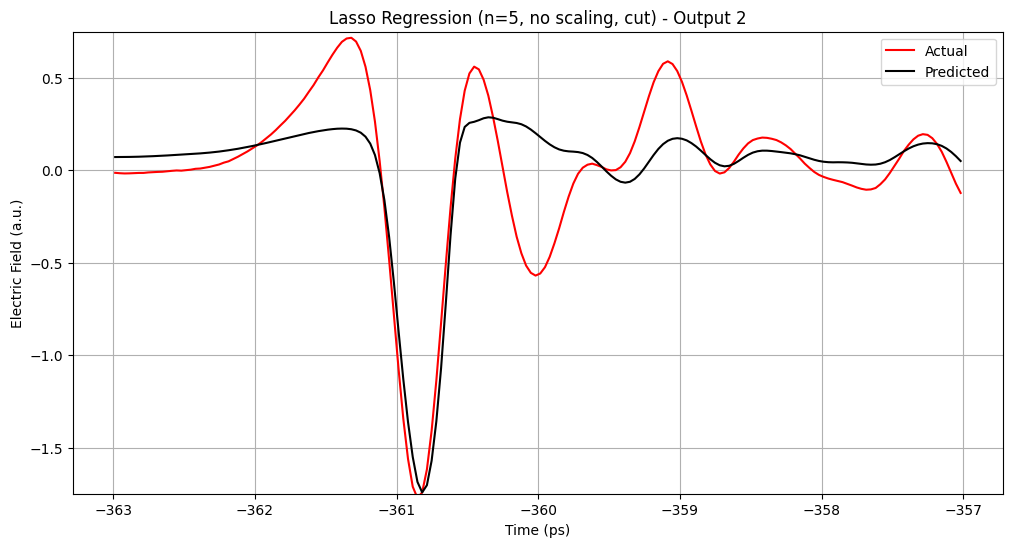

Ridge | n=10, alpha=0.5 | MSE = 0.051634


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.09279e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


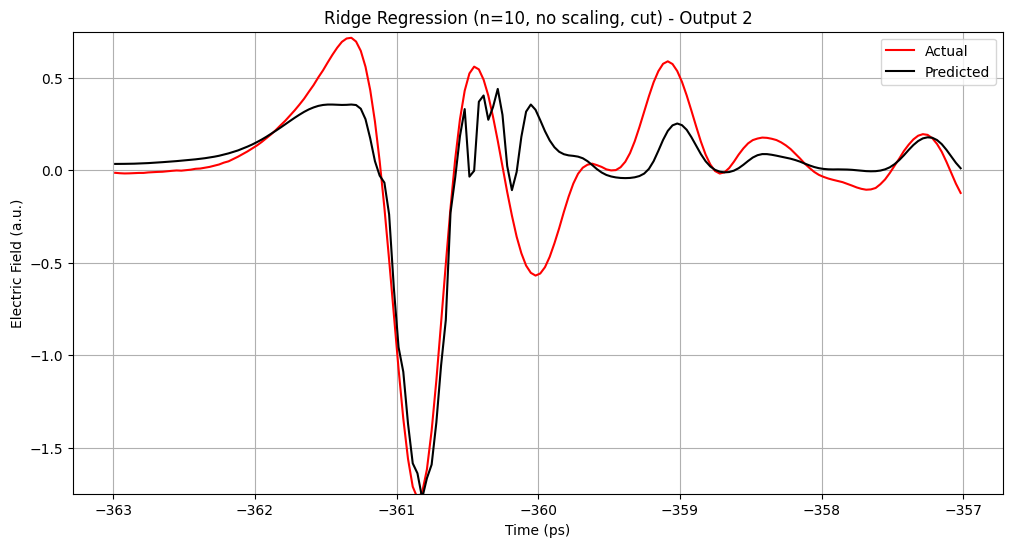

Lasso | n=10, alpha=0.01 | MSE = 0.055349


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.239e+00, tolerance: 3.564e-03
  model = cd_fast.enet_coordinate_descent(


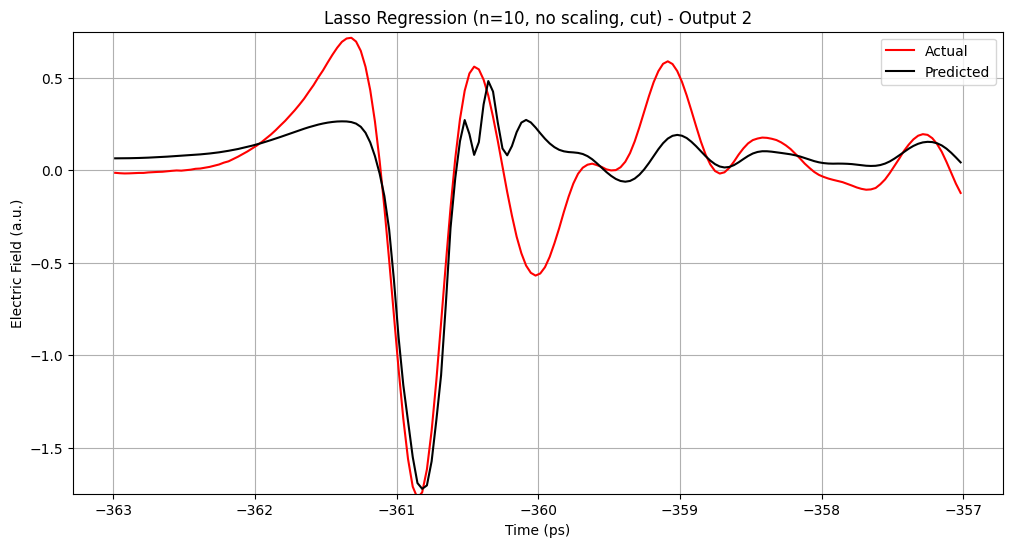

In [45]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

def train_and_plot_no_scaling_cut(E_input_cut, E_output_cut, n, model_type, alpha, t_cut, title):
    """
    Ուսուցանում է Ridge կամ Lasso ռեգրեսիոն մոդել՝ առանց նորմավորման,
    տրված պոլինոմ աստիճանով և կտրած հատվածի վրա,
    ապա նկարում է իրական և կանխատեսված ազդանշանները ժամանակի նկատմամբ։

    Մուտք՝
        E_input_cut: numpy զանգված, trimmed input electric field
        E_output_cut: numpy զանգված, trimmed output electric field
        n: պոլինոմի աստիճան
        model_type: 'ridge' կամ 'lasso'
        alpha: regularization ուժը
        t_cut: numpy զանգված, trimmed ժամանակային առանցք
        title: գրաֆիկի վերնագիր
    """

    # Ստեղծում ենք պոլինոմային ֆիչերներ՝ E_input_cut^1 ... E_input_cut^n
    X = np.column_stack([E_input_cut**i for i in range(1, n+1)])
    y = E_output_cut

    # Ընտրում և ստեղծում մոդելը
    if model_type == 'ridge':
        model = Ridge(alpha=alpha)
    elif model_type == 'lasso':
        model = Lasso(alpha=alpha, max_iter=100000)
    else:
        raise ValueError("Unknown model type.")

    # Ուսուցանում ենք մոդելը
    model.fit(X, y)

    # Կանխատեսում ենք նույն տիրույթում
    y_pred = model.predict(X)

    # Հաշվում ենք MSE
    mse = mean_squared_error(y, y_pred)
    print(f"{model_type.capitalize()} | n={n}, alpha={alpha} | MSE = {mse:.6f}")

    # Պատկերը՝ իրական և կանխատեսված ազդանշաններ ժամանակի նկատմամբ
    plt.figure(figsize=(12, 6))
    plt.plot(t_cut, y, label='Actual', color='red')
    plt.plot(t_cut, y_pred, label='Predicted', color='black')
    plt.xlabel('Time (ps)')
    plt.ylabel('Electric Field (a.u.)')
    plt.title(title)
    plt.ylim(-1.75, 0.75)
    plt.grid(True)
    plt.legend()
    plt.show()
n_values = [2, 5, 10]
alphas = {'ridge': 0.5, 'lasso': 0.01}

mask = (input_data_1['Time (ps)'].values >= -363) & (input_data_1['Time (ps)'].values <= -357)
t_cut = input_data_1['Time (ps)'].values[mask]
E_input_cut = input_data_1['Electric Field (a.u.)'].values[mask]
E_output_cut1 = output_data_1['Electric Field (a.u.)'].values[mask]
E_output_cut2 = output_data_2['Electric Field (a.u.)'].values[mask]

for output_label, E_output_cut in [('Output 1', E_output_cut1), ('Output 2', E_output_cut2)]:
    print(f"\n🔷 Ridge / Lasso results for {output_label} (No Scaling, Cut):")
    for n in n_values:
        for model_type in ['ridge', 'lasso']:
            title = f"{model_type.capitalize()} Regression (n={n}, no scaling, cut) - {output_label}"
            train_and_plot_no_scaling_cut(
                E_input_cut, E_output_cut, n=n,
                model_type=model_type,
                alpha=alphas[model_type],
                t_cut=t_cut,
                title=title
            )


